# Aplicación de gradiente descendiente por lotes

Los batches o lotes son subconjuntos del dataset que permiten la actualización de los pesos de la red con diferentes estrategias. 

En este notebook se revisan los tres tipos básicos de actulización de los pesos por gradiente descendiente utilizando batches. Estos tipos son:

 1. (Batch) Gradient Descent: se actualizan los pesos por todos los ejemplos.
 2. Stochastic Gradient Descent: se actualizan los pesos por cada ejemplo.
 3. Minibatch Gradient Descent: se actualizan los peso cada cierto número de ejemplos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch import randperm

### Preparación de dataset

Utilizaremos el dataset de cancer de mama, que es un dataset binario. Utilizamos un esquema 70-30.

In [2]:
dataset = load_breast_cancer()
X = dataset.data[:350]
Y = dataset.target[:350]

#Entrenamiento y evaluación
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#Tamaño de los datos
#Unidades de entrada
m,n = x_train.shape

pd.DataFrame(data=X, columns=dataset.feature_names)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.147100,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.71190,0.26540,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.070170,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.24160,0.18600,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.127900,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.45040,0.24300,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.105200,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.68690,0.25750,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.104300,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.40000,0.16250,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,10.26,14.71,66.20,321.6,0.09882,0.09159,0.03581,0.020370,0.1633,0.07005,...,10.88,19.48,70.89,357.1,0.1360,0.1636,0.07162,0.04074,0.2434,0.08488
346,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,0.1555,0.06048,...,13.64,27.06,86.54,562.6,0.1289,0.1352,0.04506,0.05093,0.2880,0.08083
347,14.76,14.74,94.87,668.7,0.08875,0.07780,0.04608,0.035280,0.1521,0.05912,...,17.27,17.93,114.20,880.8,0.1220,0.2009,0.21510,0.12510,0.3109,0.08187
348,11.47,16.03,73.02,402.7,0.09076,0.05886,0.02587,0.023220,0.1634,0.06372,...,12.51,20.79,79.67,475.8,0.1531,0.1120,0.09823,0.06548,0.2851,0.08763


## (Batch) Gradient Descent

En el Gradient Descent común la actualización de los pesos se da mediante el gradiente de la función de riesgo, con la regla:

$$\theta \leftarrow \theta - \eta \nabla_\theta R(\theta)$$

En este caso, la función de riesgo se define como:

$$ R(\theta) = \sum_x L\big(f(x; \theta), y\big) $$

En este caso, el gradiente se hace por cada ejemplo; de tal forma, que el gradiente se hace sobre la suma de los ejemplos:

$$\nabla_\theta R(\theta) = \sum_x \nabla_\theta L\big(f(x; \theta), y\big) $$

Por lo tanto, la actualización se hace con la suma de cada uno de los ejemplos:

$$\theta \leftarrow \theta - \eta \sum_x \nabla_\theta L\big(f(x; \theta), y\big)$$

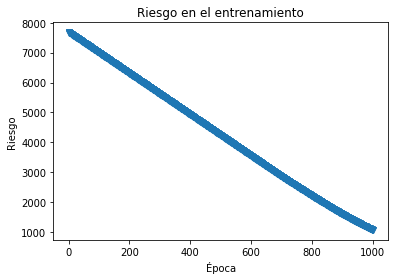

CPU times: user 424 ms, sys: 8.7 ms, total: 433 ms
Wall time: 431 ms


In [3]:
%%time

#Número de itraciones
its = 1000
#Rango de aprendizaje
lr = 1e-10

np.random.seed(0)
w = np.random.rand(n,2)/np.sqrt(n)
b = np.ones(2)

#Detenerse
stop = False
t = 0
risk = []
while  stop == False:
    #FORWARD
    #Funcion de preactivacióm
    a = np.dot(x_train,w)+b
    #Función de activación
    exp = np.exp(a-np.argmax(a))
    f = exp/exp.sum(1, keepdims=True)
    #Risk por época
    epoch_risk = -np.log(f)[range(m),y_train].sum()
    risk.append(epoch_risk)

    #Error
    err = f.copy()
    err[range(m),y_train] -= 1
    
    #Derivada
    dw = np.dot(x_train.T,err)
    db = err.sum(0)
    
    #ACTUALIZACIÓN
    #Gradiente descendiente
    w -= lr*dw
    b -= lr*db
    
    t += 1
    #Criterio de paro
    if t > its: 
        stop = True
        
plt.plot(risk, 'v-')
plt.title('Riesgo en el entrenamiento')
plt.ylabel('Riesgo')
plt.xlabel('Época')
plt.show()

In [4]:
#Predicción
def forward(X):
    #Pre-activación
    a = np.dot(X,w)+b
    #Activación
    exp = np.exp(a)
    f = exp/exp.sum(1,keepdims=True)
    #Clasificación
    cl = np.argmax(f, axis=1)
    
    return cl, f

#Evaluación
clases, probs = forward(x_test)
print(classification_report(y_test, clases))

              precision    recall  f1-score   support

           0       1.00      0.17      0.30        52
           1       0.55      1.00      0.71        53

    accuracy                           0.59       105
   macro avg       0.78      0.59      0.50       105
weighted avg       0.77      0.59      0.51       105



## Stochastic Gradient Descent

En el caso del gradiente descendiente, la actualización se hace por cada uno de los ejemplos; es decir, cada vez que se observa un ejemplo, se calcula el gradiente sobre únicamente este ejemplo y se actualizan los pesos:

$$\theta \leftarrow \theta - \eta \nabla_\theta L\big(f(x; \theta), y\big)$$

Para asegurar que en cada época se vea una configuración distinta de los ejemplos, el orden de esto por época es aleatorio. El problema con este método es que suele ser más costoso en tiempo.

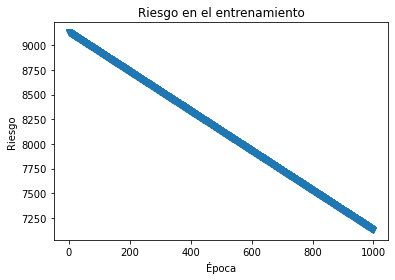

CPU times: user 7.47 s, sys: 47 ms, total: 7.51 s
Wall time: 7.48 s


In [5]:
%%time

#Número de itraciones
its = 1000
#Rango de aprendizaje
lr = 1e-10

np.random.seed(0)
w = np.random.rand(2,n)/np.sqrt(n)
b = np.ones(2)

#Riesgo
risk = []
training_data = list(zip(x_train, y_train))
for t in range(its):
    np.random.shuffle(training_data)
    example_risk = 0
    for x,y in training_data:
        #FORWARD
        #Funcion de preactivacióm
        a = np.dot(w,x) + b
        #Función de activación
        exp = np.exp(a-100)
        f = exp/exp.sum()
        #Risk por época
        example_risk -= np.log(f)[y]
        
        #Error
        err = f.copy()
        err[y] -= 1
        #print(err)
        #Derivada
        dw = np.outer(err, x)
        db = err

        #ACTUALIZACIÓN
        #Gradiente descendiente
        w -= lr*dw
        b -= lr*db
        
    risk.append(example_risk)
        
plt.plot(risk, 'v-')
plt.title('Riesgo en el entrenamiento')
plt.ylabel('Riesgo')
plt.xlabel('Época')
plt.show()

In [6]:
#Predicción
def forward(X):
    #Pre-activación
    a = np.dot(X,w.T)+b
    #Activación
    exp = np.exp(a)
    f = exp/exp.sum(1,keepdims=True)
    #Clasificación
    cl = np.argmax(f, axis=1)
    
    return cl, f

#Evaluación
clases, probs = forward(x_test)
print(classification_report(y_test, clases))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66        52
           1       0.00      0.00      0.00        53

    accuracy                           0.50       105
   macro avg       0.25      0.50      0.33       105
weighted avg       0.25      0.50      0.33       105



/home/mijangos/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Minibatch Gradient Descent

El Minibatch Gradient Descent particiona el dataset de entrenamiento en subconjuntos de un tamaño dado batch_size, de tal forma que la actualización d elos pesos se hace cada vez que se recorren los ejemplos en cada subconjunto de la partición hasta agotar todos los ejemplos del dataset:

$$\theta \leftarrow \theta - \eta \sum_{x\in B_i} \nabla_\theta L\big(f(x; \theta), y\big)$$

Aquí $B_i$ es un batch o subconjunto de una partición. Claramente $X = \bigcup_i B_i$.

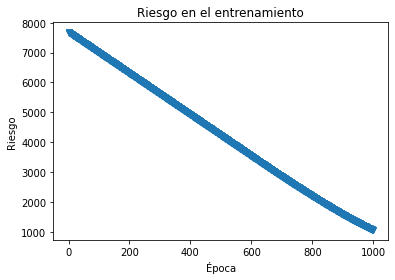

CPU times: user 932 ms, sys: 3.73 ms, total: 936 ms
Wall time: 948 ms


In [7]:
%%time

#Número de itraciones
its = 1000
#Rango de aprendizaje
lr = 1e-10
#Tamaño del minilote
batch_size = 100

np.random.seed(0)
w = np.random.rand(n,2)/np.sqrt(n)
b = np.ones(2)

#Riesgo
risk = []
training_data = list(zip(x_train, y_train))
for t in range(its):
    perm = randperm(m)
    batch_risk = 0
    for i in range(0, m, batch_size):
        idx = perm[i:i+batch_size]
        batch_x, batch_y = x_train[idx], y_train[idx]
        actual_size = batch_y.shape[0]
        #FORWARD
        #Funcion de preactivacióm
        a = np.dot(batch_x, w)+b
        #Función de activación
        exp = np.exp(a-np.argmax(a))
        f = exp/exp.sum(1, keepdims=True)
        #Risk por época
        batch_risk -= np.log(f)[range(actual_size),batch_y].sum()
        
        #Error
        err = f.copy()
        err[range(actual_size),batch_y] -= 1
        #Derivada
        dw = np.dot(batch_x.T,err)
        db = err.sum(0)

        #ACTUALIZACIÓN
        #Gradiente descendiente
        w -= lr*dw
        b -= lr*db
        
    risk.append(batch_risk)
        
plt.plot(risk, 'v-')
plt.title('Riesgo en el entrenamiento')
plt.ylabel('Riesgo')
plt.xlabel('Época')
plt.show()

In [8]:
#Predicción
def forward(X):
    #Pre-activación
    a = np.dot(X,w)+b
    #Activación
    exp = np.exp(a)
    f = exp/exp.sum(1,keepdims=True)
    #Clasificación
    cl = np.argmax(f, axis=1)
    
    return cl, f

#Evaluación
clases, probs = forward(x_test)
print(classification_report(y_test, clases))

              precision    recall  f1-score   support

           0       1.00      0.15      0.27        52
           1       0.55      1.00      0.71        53

    accuracy                           0.58       105
   macro avg       0.77      0.58      0.49       105
weighted avg       0.77      0.58      0.49       105

